In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import utils
import matplotlib.pyplot as plt
import seaborn as sns



2024-03-02 10:26:52.091578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'enformer'
data_dir = '../data/'
pdf_dir = utils.make_dir('pdfs/distance_test/')


In [3]:
tile_coords = pd.read_csv(f'../results/summary_csvs/enformer/sufficiency_test_tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000
cre_df = pd.read_csv(f'../results/summary_csvs/enformer/sufficient_CREs.csv')
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


In [4]:
cre_df.groupby(['cell_line', 'context', 'tile class']).count()['seq_id']

cell_line  context    tile class
GM12878    enhancing  Enhancer       41
           silencing  Silencer       57
K562       enhancing  Enhancer       74
           silencing  Silencer      222
PC-3       enhancing  Enhancer       35
           silencing  Silencer       97
Name: seq_id, dtype: int64

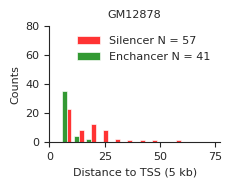

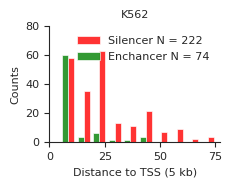

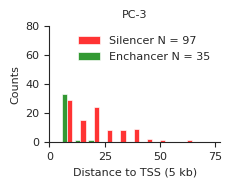

In [7]:
fontsize=8
#sns.set(font_scale = 1.3)
sns.set_style(style='white')
#plt.rcParams['xtick.major.size'] = 5
#plt.rcParams['xtick.major.width'] = 1
#plt.rcParams['ytick.major.size'] = 5
#plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[2.2,1.5])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks([0,25,50,75], fontsize=fontsize)
    ax.set_xlabel('Distance to TSS (5 kb)', fontsize=fontsize)
    ax.set_ylabel('Counts', fontsize=fontsize)
    ax.set_xlim(0,77)

    
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False, fontsize=8)
    plt.title(cell, fontsize=fontsize)
    plt.savefig(f"{pdf_dir}/frequency_vs_distance_{cell}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_122504/442719380.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',


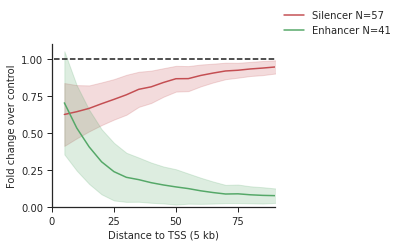

/tmp/ipykernel_122504/442719380.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',


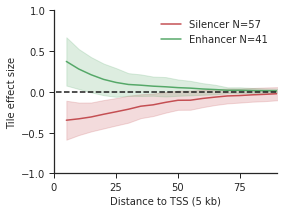

/tmp/ipykernel_122504/442719380.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',


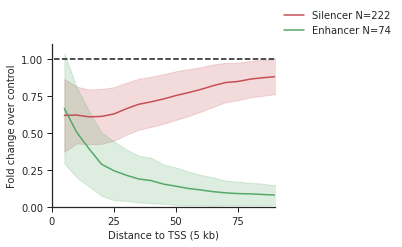

/tmp/ipykernel_122504/442719380.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',


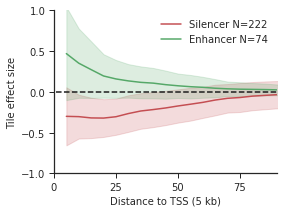

/tmp/ipykernel_122504/442719380.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',


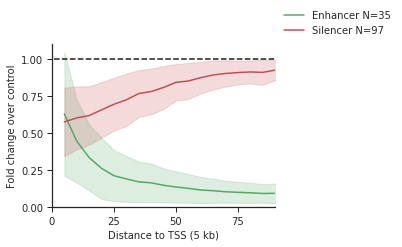

/tmp/ipykernel_122504/442719380.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',


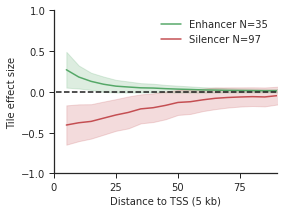

In [29]:
fontsize=10
result_normalized_effects = pd.read_csv("../results/summary_csvs/enformer/distance_test.csv")
for cell_line, df in result_normalized_effects.groupby('cell line'):
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//38}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//38}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    for y, hline_y, filename_label in [['Fold change over control', 1, 'fold_change'], ["CRE sufficiency effect", 0, 'cre_effect']]:

        fig, ax = plt.subplots(1, figsize=[4, 3])
        sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',
                  palette=my_palette, ax=ax)
        ax.plot([1, 93],[hline_y, hline_y], '--k')
        ax.set_xlim([5,90])
        # ax.set_ylim(0,1.75)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks([0,25,50,75], fontsize=fontsize)
        ax.set_xlabel('Distance to TSS (5 kb)', fontsize=fontsize)
        if y == "CRE sufficiency effect":
            ax.set_ylabel('Tile effect size', fontsize=fontsize)
            ax.set_ylim(-1,1)

        else:
            ax.set_ylabel(y, fontsize=fontsize)
            ax.set_ylim(0,1.1)


    
        plt.legend(frameon=False, bbox_to_anchor=[1,1], fontsize=fontsize)
        plt.savefig(f"{pdf_dir}/distance_test_{filename_label}_{cell_line}.pdf")
        plt.show()

In [26]:
filename_label

'cre_effect'